# Predicting MIDI drum performance style and drummer

Data is from here: https://magenta.tensorflow.org/datasets/groove

Here's the overview of predicting style and drummer of MIDI drum performances:

1. Extract midi features
2. Vectorize them and find the median and standard deviation
3. Train 3 models and find the best of them
4. Predict drummers and styles
5. Plot heatmap of original drummer and style and predicted drummer and style

In [1]:
!pip install pretty_midi
!pip install pandas
!pip install scikit-learn
!pip install seaborn

In [2]:
import pandas as pd

dataset_folder = "groove-MIDI-dataset"

df = pd.read_csv(f"{dataset_folder}/info.csv")
df = df.drop(1)
df.head()

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543,test
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500,test
5,drummer1,drummer1/eval_session,drummer1/eval_session/5,funk/groove5,84,beat,4-4,drummer1/eval_session/5_funk-groove5_84_beat_4...,drummer1/eval_session/5_funk-groove5_84_beat_4...,45.687518,test


In [3]:
import pretty_midi as pm
import numpy as np

def extract_midi_features(midi_file):
    midi = pm.PrettyMIDI(midi_file)
    notes = []
    velocities = []
    times = []

    for instrument in midi.instruments:
        if not instrument.is_drum:
            continue
        for note in instrument.notes:
            notes.append(note.pitch)
            velocities.append(note.velocity)
            times.append(note.start)

    return notes, velocities, times

def vectorize_features(notes, velocities, times):
    note_mean = np.mean(notes)
    note_std = np.std(notes)
    velocity_mean = np.mean(velocities)
    velocity_std = np.std(velocities)
    time_diffs = np.diff(times)
    time_mean = np.mean(time_diffs)
    time_std = np.std(time_diffs)

    return [note_mean, note_std, velocity_mean, velocity_std, time_mean, time_std]

In [4]:
training_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


midi_files = training_df.midi_filename
drummer_ids = training_df.drummer
styles = training_df["style"].str.split("/").str.get(0)

X = []
y_drummer = []
y_style = []

for midi_file, drummer_id, style in zip(midi_files, drummer_ids, styles):
    notes, velocities, times = extract_midi_features("groove-MIDI-dataset/" + midi_file)
    features = vectorize_features(notes, velocities, times)
    X.append(features)
    y_drummer.append(drummer_id)
    y_style.append(style)

X = np.array(X)
y = np.column_stack((y_drummer, y_style))
le_drummer = LabelEncoder()
le_style = LabelEncoder()

y[:, 0] = le_drummer.fit_transform(y[:, 0])
y[:, 1] = le_style.fit_transform(y[:, 1])
y = y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

forest = RandomForestClassifier(n_estimators=100, random_state=42)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
multi_target_forest.fit(X_train, y_train)

tree = DecisionTreeClassifier(random_state=42)
multi_target_tree = MultiOutputClassifier(tree, n_jobs=-1)
multi_target_tree.fit(X_train, y_train)

kneighbors = KNeighborsClassifier()
multi_target_kneighbors = MultiOutputClassifier(kneighbors, n_jobs=-1)
multi_target_kneighbors.fit(X_train, y_train)

y_pred = multi_target_forest.predict(X_test)
accuracy_drummer = accuracy_score(y_test[:, 0], y_pred[:, 0])
accuracy_style = accuracy_score(y_test[:, 1], y_pred[:, 1])
print(f"Forest Drummer Prediction Accuracy: {accuracy_drummer}")
print(f"Forest Style Prediction Accuracy: {accuracy_style}")

y_pred = multi_target_tree.predict(X_test)
accuracy_drummer = accuracy_score(y_test[:, 0], y_pred[:, 0])
accuracy_style = accuracy_score(y_test[:, 1], y_pred[:, 1])
print(f"Tree Drummer Prediction Accuracy: {accuracy_drummer}")
print(f"Tree Style Prediction Accuracy: {accuracy_style}")

y_pred = multi_target_kneighbors.predict(X_test)
accuracy_drummer = accuracy_score(y_test[:, 0], y_pred[:, 0])
accuracy_style = accuracy_score(y_test[:, 1], y_pred[:, 1])
print(f"KNeighbors Drummer Prediction Accuracy: {accuracy_drummer}")
print(f"KNeighbors Style Prediction Accuracy: {accuracy_style}")

Forest Drummer Prediction Accuracy: 0.6388888888888888
Forest Style Prediction Accuracy: 0.43333333333333335
Tree Drummer Prediction Accuracy: 0.4888888888888889
Tree Style Prediction Accuracy: 0.2777777777777778
KNeighbors Drummer Prediction Accuracy: 0.4722222222222222
KNeighbors Style Prediction Accuracy: 0.2611111111111111


In [6]:
def predict_drummer_and_style(midi_file, model, le_drummer, le_style):
    notes, velocities, times = extract_midi_features(midi_file)
    vectorized_features = vectorize_features(notes, velocities, times)
    prediction = model.predict([vectorized_features])
    
    predicted_drummer = le_drummer.inverse_transform([prediction[0][0]])[0]
    predicted_style = le_style.inverse_transform([prediction[0][1]])[0]
    
    return predicted_drummer, predicted_style

# Example usage
new_midi_file = 'groove-MIDI-dataset/drummer1/eval_session/10_soul-groove10_102_beat_4-4.mid'
predicted_drummer, predicted_style = predict_drummer_and_style(new_midi_file, multi_target_forest, le_drummer, le_style)
print(f"Predicted Drummer: {predicted_drummer}")
print(f"Predicted Style: {predicted_style}")

Predicted Drummer: drummer1
Predicted Style: rock


As we can see, the best one is the RandomForestClassifier. We will continue with this one.

Drummers

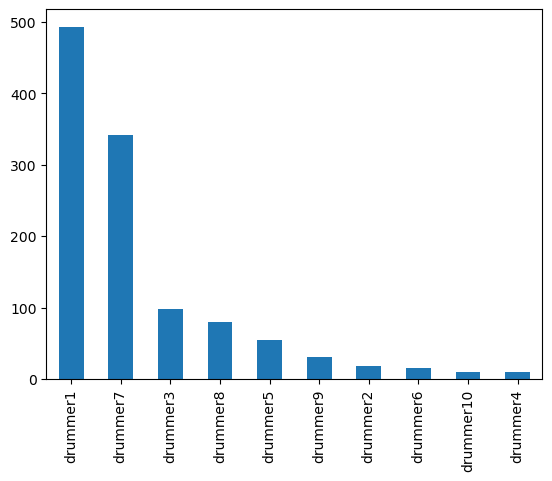

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

value_counts = df['drummer'].value_counts()
value_counts.plot(kind='bar')
plt.show()

In [8]:
y_pred = multi_target_forest.predict(X_test)
predicted_drummers = le_drummer.inverse_transform(y_pred[:, 0])
predicted_styles = le_style.inverse_transform(y_pred[:, 1])
predictions_df = pd.DataFrame({
    'drummer': predicted_drummers,
    'style': predicted_styles
})

In [9]:
table_predictions = predictions_df.pivot_table(index='drummer', columns='style', aggfunc='size', fill_value=0)
table_predictions = table_predictions.div(table_predictions.sum(axis=1), axis=0)
table_predictions.head()

style,afrobeat,afrocuban,country,dance,funk,gospel,hiphop,jazz,latin,neworleans,punk,reggae,rock
drummer,,,,,,,,,,,,,
drummer1,0.000000,0.023256,0.011628,0.0,0.22093,0.023256,0.011628,0.139535,0.104651,0.000000,0.05814,0.034884,0.372093
drummer2,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
drummer3,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
drummer5,0.000000,0.000000,0.000000,0.0,0.25000,0.000000,0.000000,0.000000,0.500000,0.000000,0.00000,0.000000,0.250000
drummer7,0.017241,0.000000,0.000000,0.0,0.12069,0.000000,0.155172,0.017241,0.000000,0.017241,0.00000,0.017241,0.655172


In [10]:
# Extract actual drummers and styles from the test set
actual_drummers = le_drummer.inverse_transform(y_test[:, 0])
actual_styles = le_style.inverse_transform(y_test[:, 1])

# Create a DataFrame with the actual labels
actual_df = pd.DataFrame({
    'drummer': actual_drummers,
    'style': actual_styles
})

pivot_table_actual = actual_df.pivot_table(index='drummer', columns='style', aggfunc='size', fill_value=0)

pivot_table_actual = pivot_table_actual.div(pivot_table_actual.sum(axis=1), axis=0)

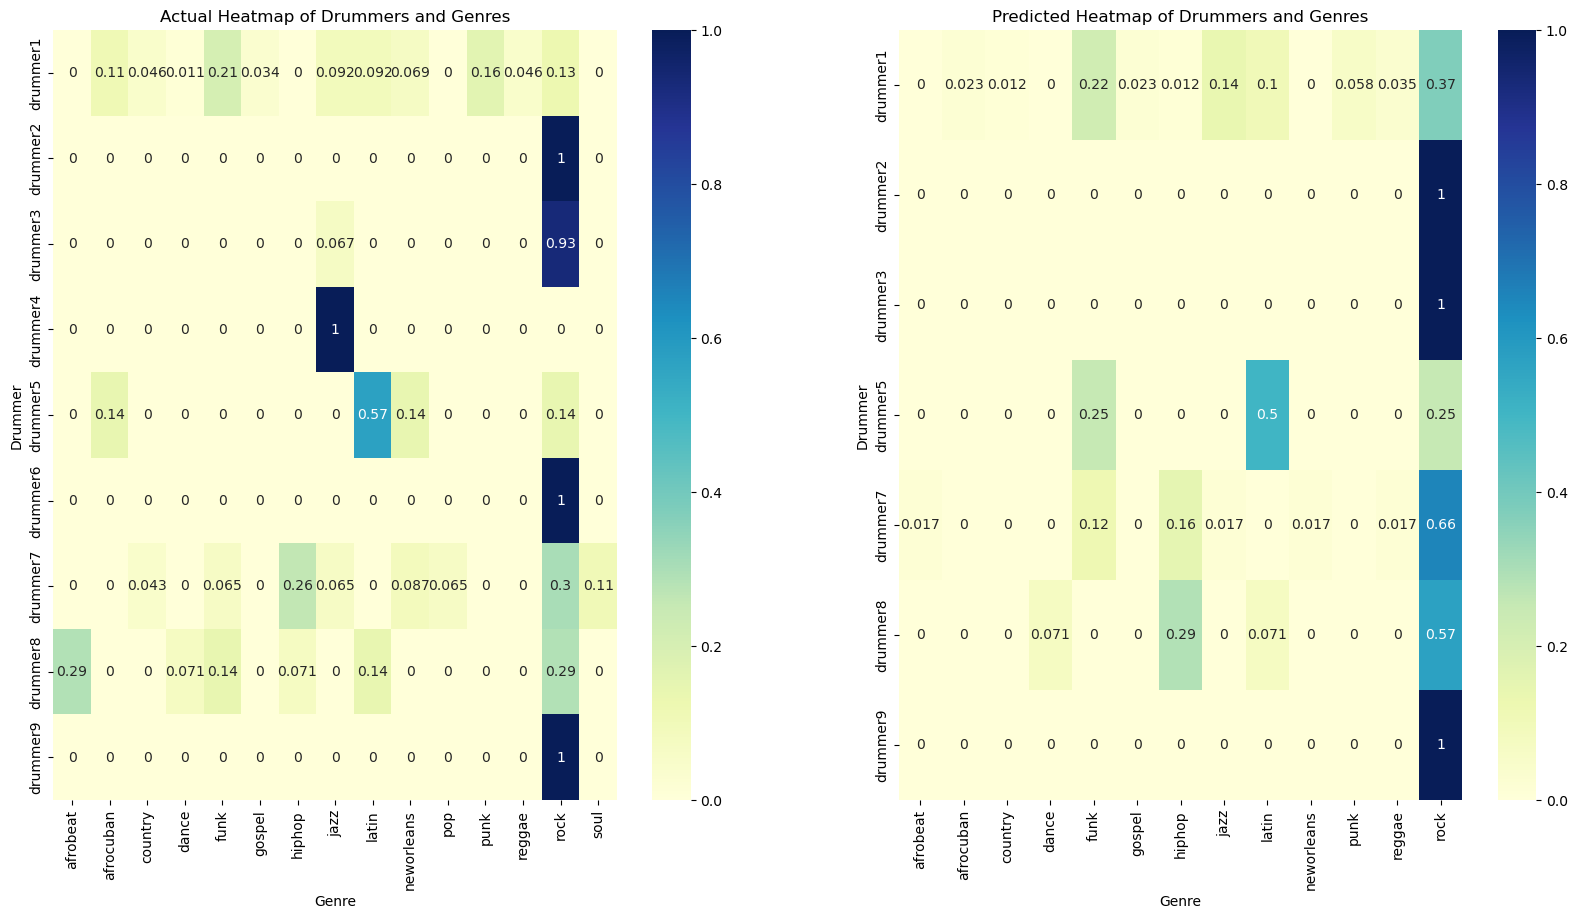

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(pivot_table_actual, annot=True, cmap="YlGnBu", cbar=True, ax=axes[0])
axes[0].set_title('Actual Heatmap of Drummers and Genres')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Drummer')

sns.heatmap(table_predictions, annot=True, cmap="YlGnBu", cbar=True, ax=axes[1])
axes[1].set_title('Predicted Heatmap of Drummers and Genres')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Drummer')

plt.show()

Here we can see, that even though our RandomForestClassifier was the best, it still isn't good enough. We are for example missing soul predictions, which should be drummer9, but it thinks it is rock.